### Aluno: André Sampaio

e-mail: as2@cesar.school

# Classificação de Pistaches com Rede Neural
## Dataset: Pistachio 16 Features

Neste notebook vamos:

1. Carregar o dataset `Pistachio_16_Features_Dataset.csv`.
2. Fazer eventuais preparações dos dados (limpeza, padronização, divisão treino/teste).
3. Definir uma rede neural totalmente conectada (feedforward) em PyTorch.
4. Treinar o modelo.
5. Avaliar a performance (perda, acurácia e matriz de confusão).
6. Registrar um comentário final sobre o processo (overfitting/underfitting, dificuldades e ajustes).


## Importação das bibliotecas

In [138]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importamos funções do scikit-learn para divisão de dados, escalonamento e métricas
from sklearn.model_selection import train_test_split  # divide os dados em treino e teste
from sklearn.preprocessing import StandardScaler, LabelEncoder  # padroniza features e codifica rótulos
from sklearn.metrics import (  # métricas para avaliar o modelo
    accuracy_score,            # calcula acurácia
    confusion_matrix,          # calcula matriz de confusão
    ConfusionMatrixDisplay,    # plota matriz de confusão
    classification_report      # resumo com precisão, recall e F1-score
)

# Importamos o PyTorch, biblioteca principal para criação e treino de redes neurais
import torch

# Importamos o módulo de redes neurais do PyTorch
import torch.nn as nn

# Importamos funções auxiliares (por exemplo, funções de ativação) do PyTorch
import torch.nn.functional as F

# Importamos o utilitário para criar datasets e dataloaders no PyTorch
from torch.utils.data import TensorDataset, DataLoader

# Definimos o dispositivo de execução: se houver GPU disponível (cuda), usamos; caso contrário, usamos CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Exibimos o dispositivo que será utilizado (cuda ou cpu)
device

device(type='cpu')

## Carregamento e preparação do dataset

Aqui vamos:

1. Ler o arquivo CSV a partir do caminho informado.
2. Inspecionar o formato dos dados.
3. Separar **features (X)** e **rótulo (y)**.
4. Codificar a variável alvo (caso seja categórica com rótulos de texto).
5. Fazer o split em treino e teste.
6. Padronizar as features numéricas com `StandardScaler`.
7. Converter para tensores PyTorch e criar `DataLoader`s.


In [139]:
# Definimos o caminho completo para o arquivo CSV conforme informado no enunciado
caminho_csv = "C:/Users/andre/OneDrive/Documentos/André Sampaio/Curso Engenharia de Dados/RNA Deep Learning/Trabalho Final/Pistachio_16_Features_Dataset.csv"
df = pd.read_csv(caminho_csv, sep=";", decimal=",")

df.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,Class
0,63391,1568.405,390.3396,236.7461,0.7951,284.0984,0.8665,73160,0.6394,1.6488,0.3238,0.7278,0.0062,0.0037,0.5297,0.8734,Kirmizi_Pistachio
1,68358,1942.187,410.8594,234.7525,0.8207,295.0188,0.8765,77991,0.6772,1.7502,0.2277,0.7181,0.0060,0.0034,0.5156,0.9024,Kirmizi_Pistachio
2,73589,1246.538,452.3630,220.5547,0.8731,306.0987,0.9172,80234,0.7127,2.0510,0.5951,0.6767,0.0061,0.0030,0.4579,0.9391,Kirmizi_Pistachio
3,71106,1445.261,429.5291,216.0765,0.8643,300.8903,0.9589,74153,0.7028,1.9879,0.4278,0.7005,0.0060,0.0030,0.4907,0.9755,Kirmizi_Pistachio
4,80087,1251.524,469.3783,220.9344,0.8823,319.3273,0.9657,82929,0.7459,2.1245,0.6425,0.6803,0.0059,0.0028,0.4628,0.9833,Kirmizi_Pistachio


In [140]:
# Exibimos informações gerais do DataFrame:
# - número de linhas e colunas
# - tipo de cada coluna
# - quantidade de valores não nulos
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AREA           2148 non-null   int64  
 1   PERIMETER      2148 non-null   float64
 2   MAJOR_AXIS     2148 non-null   float64
 3   MINOR_AXIS     2148 non-null   float64
 4   ECCENTRICITY   2148 non-null   float64
 5   EQDIASQ        2148 non-null   float64
 6   SOLIDITY       2148 non-null   float64
 7   CONVEX_AREA    2148 non-null   int64  
 8   EXTENT         2148 non-null   float64
 9   ASPECT_RATIO   2148 non-null   float64
 10  ROUNDNESS      2148 non-null   float64
 11  COMPACTNESS    2148 non-null   float64
 12  SHAPEFACTOR_1  2148 non-null   float64
 13  SHAPEFACTOR_2  2148 non-null   float64
 14  SHAPEFACTOR_3  2148 non-null   float64
 15  SHAPEFACTOR_4  2148 non-null   float64
 16  Class          2148 non-null   object 
dtypes: float64(14), int64(2), object(1)
memory usage: 28

In [141]:
# Definimos o nome da coluna alvo, ou seja, a coluna que contém a classe do pistache
nome_coluna_alvo = "Class"

# Verificamos se a coluna alvo realmente existe nas colunas do DataFrame
if nome_coluna_alvo not in df.columns:
    # Se não existir, levantamos um erro informando quais colunas estão disponíveis
    raise ValueError(
        f"A coluna alvo '{nome_coluna_alvo}' não foi encontrada no DataFrame. "
        f"Colunas disponíveis: {df.columns.tolist()}"
    )

# Separamos as features (X) removendo a coluna alvo do DataFrame
X = df.drop(columns=[nome_coluna_alvo])

# Separamos a variável alvo (y), contendo apenas a coluna de classe
y = df[nome_coluna_alvo]

# Caso a coluna alvo seja do tipo texto (object), precisamos codificá-la em números
if y.dtype == "object":
    # Criamos um objeto LabelEncoder para converter rótulos de texto em inteiros
    le = LabelEncoder()
    # Aplicamos o LabelEncoder na coluna y
    y = le.fit_transform(y)
else:
    # Se a coluna alvo já for numérica, apenas mostramos os valores únicos
    valores_unicos = np.unique(y)
    print("Valores únicos da variável alvo:", valores_unicos)

# Exibimos as primeiras linhas de X e os primeiros valores de y para conferência
X.head(), y[:10]

(    AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
 0  63391   1568.405    390.3396    236.7461        0.7951  284.0984    0.8665   
 1  68358   1942.187    410.8594    234.7525        0.8207  295.0188    0.8765   
 2  73589   1246.538    452.3630    220.5547        0.8731  306.0987    0.9172   
 3  71106   1445.261    429.5291    216.0765        0.8643  300.8903    0.9589   
 4  80087   1251.524    469.3783    220.9344        0.8823  319.3273    0.9657   
 
    CONVEX_AREA  EXTENT  ASPECT_RATIO  ROUNDNESS  COMPACTNESS  SHAPEFACTOR_1  \
 0        73160  0.6394        1.6488     0.3238       0.7278         0.0062   
 1        77991  0.6772        1.7502     0.2277       0.7181         0.0060   
 2        80234  0.7127        2.0510     0.5951       0.6767         0.0061   
 3        74153  0.7028        1.9879     0.4278       0.7005         0.0060   
 4        82929  0.7459        2.1245     0.6425       0.6803         0.0059   
 
    SHAPEFACTOR_2  SHAPE

In [142]:
# Dividimos os dados em conjuntos de treino e teste
# random_state=42 garante reprodutibilidade
# stratify=y mantém a proporção das classes em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Criamos um objeto StandardScaler, que padroniza os dados (média 0, desvio padrão 1)
scaler = StandardScaler()

# Ajustamos o scaler nos dados de treino e transformamos os dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# Transformamos os dados de teste usando os mesmos parâmetros do treino
X_test_scaled = scaler.transform(X_test)

# Convertendo o array de treino escalonado em um tensor PyTorch do tipo float32
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)

# Convertendo o array de teste escalonado em um tensor PyTorch do tipo float32
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convertendo y_train em tensor PyTorch do tipo float32 e ajustando o formato para coluna
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

# Convertendo y_test em tensor PyTorch do tipo float32 e ajustando o formato para coluna
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Definimos o tamanho do batch, ou seja, quantas amostras serão usadas por iteração de treino
batch_size = 64

# Criamos um TensorDataset de treino juntando X e y de treino
train_dataset = TensorDataset(X_train_t, y_train_t)

# Criamos um TensorDataset de teste juntando X e y de teste
test_dataset = TensorDataset(X_test_t, y_test_t)

# Criamos um DataLoader para o conjunto de treino, que embaralha os dados a cada época
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Criamos um DataLoader para o conjunto de teste, sem embaralhar os dados
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Exibimos o formato (shape) dos tensores de treino para conferência
X_train_t.shape, y_train_t.shape

(torch.Size([1718, 16]), torch.Size([1718, 1]))

## Criação da rede

Vamos criar uma rede totalmente conectada (feedforward), com:

- Camada de entrada: número de features do dataset.
- Algumas camadas ocultas com ReLU.
- Camada de saída: 1 neurônio com saída para classificação binária (0/1).

Usaremos `BCEWithLogitsLoss`, então a última camada **não** terá ativação sigmoide dentro do `forward`
(a sigmoide será aplicada apenas para calcular previsões).


In [143]:
# Obtemos a quantidade de features de entrada a partir do número de colunas de X_train_t
input_dim = X_train_t.shape[1]

# Definimos a classe da rede neural chamada PistachioNet, que herda de nn.Module
class PistachioNet(nn.Module):
    # Método construtor: aqui definimos as camadas da rede
    def __init__(self):
        # Chamamos o construtor da classe pai (nn.Module)
        super(PistachioNet, self).__init__()
        # Primeira camada totalmente conectada: da dimensão de entrada para 32 neurônios
        self.fc1 = nn.Linear(input_dim, 32)
        # Segunda camada totalmente conectada: de 32 neurônios para 16 neurônios
        self.fc2 = nn.Linear(32, 16)
        # Camada de saída: de 16 neurônios para 1 neurônio (classificação binária)
        self.fc3 = nn.Linear(16, 1)
        # Camada de dropout para reduzir overfitting, com taxa de 20%
        self.dropout = nn.Dropout(0.2)

    # Método forward: define como os dados fluem pelas camadas da rede
    def forward(self, x):
        # Passamos os dados pela primeira camada e aplicamos a função de ativação ReLU
        x = F.relu(self.fc1(x))
        # Aplicamos dropout após a primeira camada
        x = self.dropout(x)
        # Passamos o resultado pela segunda camada e aplicamos ReLU
        x = F.relu(self.fc2(x))
        # Aplicamos dropout após a segunda camada
        x = self.dropout(x)
        # Passamos o resultado pela camada de saída sem ativação (logits)
        x = self.fc3(x)
        # Retornamos os logits (valores antes da sigmoide)
        return x

# Instanciamos o modelo a partir da classe PistachioNet
model = PistachioNet()

# Movemos o modelo para o dispositivo escolhido (GPU ou CPU)
model = model.to(device)

# Exibimos a arquitetura da rede neural
model

PistachioNet(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Configuração do treinamento

Aqui definimos:

- Função de custo: `BCEWithLogitsLoss` (para classificação binária).
- Otimizador: `Adam`.
- Taxa de aprendizado (`learning_rate`).
- Número de épocas (`epochs`).

In [144]:
# Definimos a taxa de aprendizado (learning rate) do otimizador
learning_rate = 1e-3

# Definimos o número de épocas de treinamento (quantas vezes passaremos por todo o dataset)
epochs = 30

# Definimos a função de custo (loss function) para problemas de classificação binária com logits
criterion = nn.BCEWithLogitsLoss()

# Definimos o otimizador Adam, que atualizará os pesos da rede durante o treino
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Treinamento do modelo

Vamos treinar a rede por algumas épocas, registrando:

- Perda (loss) no conjunto de treino e teste.
- Acurácia no conjunto de teste em cada época.


In [145]:
# Criamos um dicionário para armazenar o histórico de métricas ao longo das épocas
history = {
    "train_loss": [],  # lista para armazenar a loss de treino
    "test_loss": [],   # lista para armazenar a loss de teste
    "test_acc": []     # lista para armazenar a acurácia no teste
}

# Iniciamos o loop de treinamento pelas épocas
for epoch in range(1, epochs + 1):
    # Colocamos o modelo em modo de treino (ativa dropout, batchnorm, etc. se houver)
    model.train()
    # Inicializamos um acumulador para a loss de treino da época
    running_train_loss = 0.0
    
    # Iteramos sobre os batches gerados pelo DataLoader de treino
    for X_batch, y_batch in train_loader:
        # Movemos o batch de features para o dispositivo (GPU/CPU)
        X_batch = X_batch.to(device)
        # Movemos o batch de rótulos para o dispositivo (GPU/CPU)
        y_batch = y_batch.to(device)

        # Zeramos os gradientes acumulados do otimizador
        optimizer.zero_grad()
        
        # Fazemos a passagem para frente (forward) do modelo com o batch de entrada
        outputs = model(X_batch)
        
        # Calculamos a loss do batch comparando as previsões com os rótulos verdadeiros
        loss = criterion(outputs, y_batch)
        
        # Calculamos os gradientes (backpropagation)
        loss.backward()
        
        # Atualizamos os pesos da rede com base nos gradientes calculados
        optimizer.step()
        
        # Acumulamos a loss do batch multiplicada pelo tamanho do batch
        running_train_loss += loss.item() * X_batch.size(0)
    
    # Calculamos a loss média da época no conjunto de treino
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    
    # Colocamos o modelo em modo de avaliação (desativa dropout, etc.)
    model.eval()
    # Inicializamos o acumulador para a loss de teste da época
    running_test_loss = 0.0
    # Criamos listas para armazenar todas as previsões e rótulos verdadeiros
    all_preds = []
    all_labels = []

    # Desativamos o cálculo de gradiente, pois estamos apenas avaliando
    with torch.no_grad():
        # Iteramos sobre os batches do conjunto de teste
        for X_batch, y_batch in test_loader:
            # Movemos o batch de entrada para o dispositivo
            X_batch = X_batch.to(device)
            # Movemos os rótulos para o dispositivo
            y_batch = y_batch.to(device)
            
            # Fazemos a passagem para frente (forward) no modelo
            outputs = model(X_batch)
            
            # Calculamos a loss do batch de teste
            loss = criterion(outputs, y_batch)
            
            # Acumulamos a loss de teste multiplicando pelo tamanho do batch
            running_test_loss += loss.item() * X_batch.size(0)
            
            # Aplicamos a função sigmoide para converter logits em probabilidades
            probs = torch.sigmoid(outputs)
            
            # Convertendo probabilidades em previsões binárias (0 ou 1) com limiar de 0.5
            preds = (probs >= 0.5).float()
            
            # Armazenamos as previsões convertidas para numpy na lista all_preds
            all_preds.append(preds.cpu().numpy())
            # Armazenamos os rótulos verdadeiros convertidos para numpy na lista all_labels
            all_labels.append(y_batch.cpu().numpy())

    # Calculamos a loss média da época no conjunto de teste
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    
    # Empilhamos verticalmente todas as previsões feitas na época
    all_preds = np.vstack(all_preds)
    
    # Empilhamos verticalmente todos os rótulos verdadeiros da época
    all_labels = np.vstack(all_labels)
    
    # Calculamos a acurácia da época no conjunto de teste
    epoch_test_acc = accuracy_score(all_labels, all_preds)
    
    # Registramos a loss de treino da época no histórico
    history["train_loss"].append(epoch_train_loss)
    
    # Registramos a loss de teste da época no histórico
    history["test_loss"].append(epoch_test_loss)
    
    # Registramos a acurácia de teste da época no histórico
    history["test_acc"].append(epoch_test_acc)
    
    # Imprimimos um resumo das métricas da época
    print(
        f"Época {epoch:02d}/{epochs} | "
        f"Loss Treino: {epoch_train_loss:.4f} | "
        f"Loss Teste: {epoch_test_loss:.4f} | "
        f"Acurácia Teste: {epoch_test_acc:.4f}"
    )

Época 01/30 | Loss Treino: 0.6355 | Loss Teste: 0.5988 | Acurácia Teste: 0.6419
Época 02/30 | Loss Treino: 0.5376 | Loss Teste: 0.4880 | Acurácia Teste: 0.8302
Época 03/30 | Loss Treino: 0.4195 | Loss Teste: 0.3944 | Acurácia Teste: 0.8326
Época 04/30 | Loss Treino: 0.3541 | Loss Teste: 0.3627 | Acurácia Teste: 0.8326
Época 05/30 | Loss Treino: 0.3246 | Loss Teste: 0.3538 | Acurácia Teste: 0.8419
Época 06/30 | Loss Treino: 0.3239 | Loss Teste: 0.3511 | Acurácia Teste: 0.8512
Época 07/30 | Loss Treino: 0.3215 | Loss Teste: 0.3483 | Acurácia Teste: 0.8535
Época 08/30 | Loss Treino: 0.3119 | Loss Teste: 0.3477 | Acurácia Teste: 0.8581
Época 09/30 | Loss Treino: 0.3104 | Loss Teste: 0.3465 | Acurácia Teste: 0.8605
Época 10/30 | Loss Treino: 0.3045 | Loss Teste: 0.3456 | Acurácia Teste: 0.8581
Época 11/30 | Loss Treino: 0.3103 | Loss Teste: 0.3458 | Acurácia Teste: 0.8558
Época 12/30 | Loss Treino: 0.3078 | Loss Teste: 0.3423 | Acurácia Teste: 0.8558
Época 13/30 | Loss Treino: 0.3085 | Loss

## Análise simples da performance (loss e acurácia)

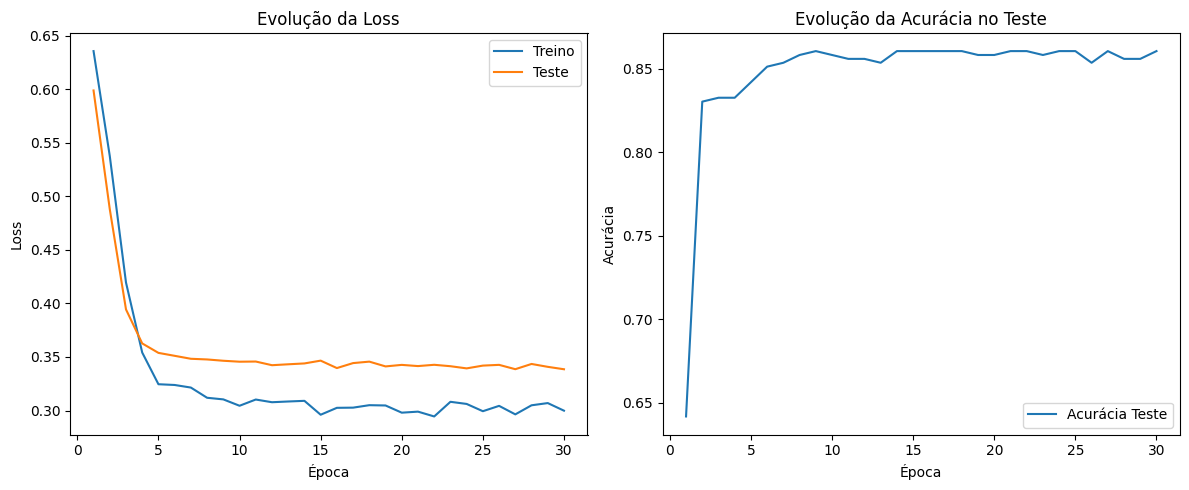

In [146]:
# Criamos um range de épocas para o eixo x dos gráficos
epocas_range = range(1, epochs + 1)

# Definimos o tamanho da figura para exibir dois gráficos lado a lado
plt.figure(figsize=(12, 5))

# Primeiro subplot: gráfico de loss de treino e teste
plt.subplot(1, 2, 1)
# Plotamos a loss de treino ao longo das épocas
plt.plot(epocas_range, history["train_loss"], label="Treino")
# Plotamos a loss de teste ao longo das épocas
plt.plot(epocas_range, history["test_loss"], label="Teste")
# Definimos o rótulo do eixo x
plt.xlabel("Época")
# Definimos o rótulo do eixo y
plt.ylabel("Loss")
# Definimos o título do gráfico
plt.title("Evolução da Loss")
# Exibimos a legenda para identificar cada curva
plt.legend()

# Segundo subplot: gráfico de acurácia no teste
plt.subplot(1, 2, 2)
# Plotamos a acurácia no conjunto de teste ao longo das épocas
plt.plot(epocas_range, history["test_acc"], label="Acurácia Teste")
# Definimos o rótulo do eixo x
plt.xlabel("Época")
# Definimos o rótulo do eixo y
plt.ylabel("Acurácia")
# Definimos o título do gráfico
plt.title("Evolução da Acurácia no Teste")
# Exibimos a legenda
plt.legend()

# Ajustamos o layout para evitar sobreposição de elementos
plt.tight_layout()
# Exibimos os gráficos na tela
plt.show()

## Avaliação final do modelo

Agora vamos avaliar o modelo no conjunto de teste:

- Acurácia final.
- Matriz de confusão.
- `classification_report` (precisão, revocação e F1 por classe).

Acurácia final no conjunto de teste: 0.8605

Relatório de classificação:

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       247
         1.0       0.84      0.83      0.83       183

    accuracy                           0.86       430
   macro avg       0.86      0.86      0.86       430
weighted avg       0.86      0.86      0.86       430



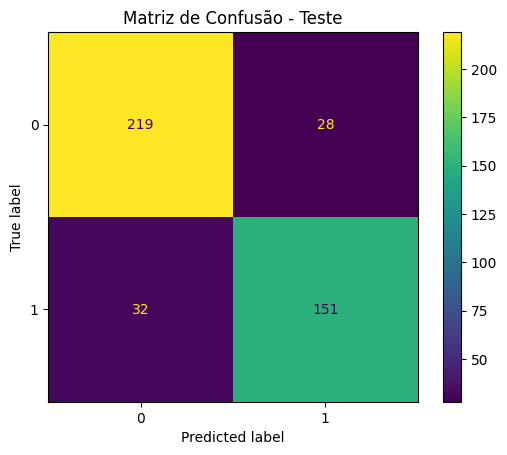

In [147]:
# Colocamos o modelo em modo de avaliação para fazer a predição final
model.eval()

# Desativamos o cálculo de gradiente, pois estamos apenas inferindo
with torch.no_grad():
    # Fazemos a passagem para frente (forward) com todos os dados de teste
    outputs = model(X_test_t.to(device))
    # Aplicamos a função sigmoide para converter logits em probabilidades
    probs = torch.sigmoid(outputs)
    # Convertendo probabilidades em rótulos binários (0 ou 1) com limiar 0.5
    preds = (probs >= 0.5).float().cpu().numpy()

# Convertendo os rótulos verdadeiros de teste para numpy
y_true = y_test_t.numpy()

# Calculamos a acurácia final no conjunto de teste
acc_final = accuracy_score(y_true, preds)

# Calculamos a matriz de confusão entre rótulos verdadeiros e previstos
cm = confusion_matrix(y_true, preds)

# Imprimimos a acurácia final formatada com 4 casas decimais
print(f"Acurácia final no conjunto de teste: {acc_final:.4f}")

# Imprimimos o relatório de classificação, com precisão, recall e F1-score por classe
print("\nRelatório de classificação:\n")
print(classification_report(y_true, preds))

# Criamos um objeto de exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Chamamos o método plot para desenhar a matriz de confusão
disp.plot()

# Definimos o título do gráfico da matriz de confusão
plt.title("Matriz de Confusão - Teste")

# Exibimos o gráfico
plt.show()

## Comentários sobre o processo e experiência

Durante o treinamento dessa rede neural para classificar os pistaches em duas classes, o primeiro passo foi garantir que os dados estivessem bem preparados. Isso envolveu separar corretamente a variável alvo (a coluna *Class*), padronizar as 16 features numéricas e dividir o conjunto em treino e teste mantendo a proporção das classes (estratificação). A padronização foi importante para que todas as features ficassem na mesma escala, o que ajuda bastante a rede a convergir mais rápido e de forma mais estável.

No modelo em si, optei por uma arquitetura relativamente simples: algumas camadas totalmente conectadas com funções de ativação ReLU e uma camada de saída com um único neurônio para classificação binária. Também incluí *dropout* com taxa de 0,2 para reduzir overfitting, já que redes neurais tendem a "decorar" o conjunto de treino quando têm muitos parâmetros. A função de custo escolhida foi `BCEWithLogitsLoss`, que é adequada para problemas binários e já combina a sigmoide internamente com a entropia cruzada.

Durante o treinamento, acompanhei tanto a loss quanto a acurácia no conjunto de teste a cada época. Quando a loss de treino cai muito e a de teste começa a subir, isso é um sinal típico de overfitting; se isso ocorresse de forma clara, alguns ajustes possíveis seriam: aumentar o dropout, reduzir a complexidade da rede (menos neurônios/camadas), ou usar *early stopping* (parar o treinamento antes de "estragar" o modelo). Se, ao contrário, a loss de treino ficasse alta e a acurácia baixa, poderíamos estar diante de underfitting, e aí faria sentido testar modelos um pouco mais complexos ou treinar por mais épocas.

No geral, a experiência segue o mesmo padrão do exemplo do MNIST: definimos o modelo, configuramos o treinamento, acompanhamos as métricas e, ao final, usamos a matriz de confusão e o relatório de classificação para entender melhor onde o modelo acerta e onde ele erra. A principal dificuldade prática costuma ser encontrar o equilíbrio entre complexidade do modelo e generalização — e isso é feito na base da experimentação: ajustando *learning rate*, número de épocas, tamanho das camadas e o nível de regularização até encontrar um desempenho satisfatório sem exagerar no overfitting.
